# 6.1 从全连接层到卷积
- **目录**
  - 6.1.1 不变性
  - 6.1.2 多层感知机的限制
    - 6.1.2.1 平移不变性
    - 6.1.2.2 局部性
  - 6.1.3 卷积
  - 6.1.4 “沃尔多在哪里”回顾
    - 6.1.4.1 通道

我们之前讨论的多层感知机十分适合处理表格数据，其中行对应样本，列对应特征。
对于表格数据，我们寻找的模式可能涉及特征之间的交互，但是我们**不能预先假设任何与特征交互相关的先验结构**。
此时，多层感知机可能是最好的选择，然而对于高维感知数据，这种**缺少结构的网络**可能会变得不实用。

例如，在之前猫狗分类的例子中：假设我们有一个足够充分的照片数据集，数据集中是拥有标注的照片，每张照片具有百万级像素，这意味着网络的每次输入都有一百万个维度。
即使将隐藏层维度降低到1000，这个全连接层也将有$10^6 \times 10^3 = 10^9$个参数。
想要训练这个模型将不可实现，因为需要有大量的GPU、分布式优化训练的经验和超乎常人的耐心。

有些读者可能会反对这个观点，认为要求百万像素的分辨率可能不是必要的。
然而，即使分辨率减小为十万像素，使用1000个隐藏单元的隐藏层也可能不足以学习到**良好的图像特征**，在真实的系统中我们仍然需要数十亿个参数。
此外，拟合如此多的参数还需要收集大量的数据。
然而，如今人类和机器都能很好地区分猫和狗：这是因为图像中本就拥有丰富的结构，而这些结构可以被人类和机器学习模型使用。
**卷积神经网络（convolutional neural networks，CNN）** 是机器学习利用自然图像中一些已知结构的创造性方法。

- **要点：**
  - 多层感知机适合处理表格数据，但对于高维感知数据（如图像），缺乏结构的网络可能不够实用。
  - 高分辨率图像输入导致全连接层参数数量巨大，训练这些模型需要大量的计算资源、专业知识和耐心。
  - 即使降低分辨率，全连接网络可能仍然无法学习到良好的图像特征，而且需要数十亿个参数。
  - 图像中本身包含丰富的结构信息，可以被人类或机器学习模型利用。
  - 卷积神经网络（CNN）是一种创造性的方法，可以充分利用自然图像中的已知结构。

## 6.1.1 不变性

想象一下，假设你想从一张图片中找到某个物体。
**合理的假设是：无论哪种方法找到这个物体，都应该和物体的位置无关。**
理想情况下，我们的系统应该能够利用常识：猪通常不在天上飞，飞机通常不在水里游泳。
但是，如果一只猪出现在图片顶部，我们还是应该认出它。
我们可以从儿童游戏”沃尔多在哪里”（图6.1.1）中得到灵感：
在这个游戏中包含了许多充斥着活动的混乱场景，而沃尔多通常潜伏在一些不太可能的位置，读者的目标就是找出他。
尽管沃尔多的装扮很有特点，但是在眼花缭乱的场景中找到他也如大海捞针。
然而沃尔多的样子并不取决于他潜藏的地方，因此我们可以使用一个“沃尔多检测器”扫描图像。
该检测器将图像分割成多个区域，并为每个区域包含沃尔多的可能性打分。
卷积神经网络正是将**空间不变性（spatial invariance）** 的这一概念系统化，从而基于这个模型使用较少的参数来学习有用的表示。

![沃尔多游戏示例图。](../img/where-wally-walker-books.jpg)

<center>图6.1.1 沃尔多游戏示例图</center>

现在，我们将上述想法总结一下，从而帮助我们设计适合于计算机视觉的神经网络架构：

1. **平移不变性（translation invariance）**：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。
1. **局部性（locality）**：神经网络的前面几层应该只探索输入图像中的局部区域(比如卷积神经网络会**优先考虑图像中相邻像素之间的关联性**)，而**不过度在意图像中相隔较远区域的关系**，这就是“局部性”原则。最终，可以**聚合这些局部特征**（比如**纹理**、**边缘**、**形状**等），以在整个图像级别进行预测。

让我们看看这些原则是如何转化为数学表示的。

- **要点：**
  - 空间不变性：卷积神经网络利用空间不变性原则，使用较少的参数学习有用表示。
  - 平移不变性：神经网络应对图像中相同区域具有相似反应，无论检测对象出现在何处，而CNN具备此能力。
  - 局部性：神经网络应关注输入图像的局部区域，而非过度考虑相隔较远的区域关系。
  - 通过聚合局部特征，在整个图像级别进行预测。
  - 上述原则有助于设计适用于计算机视觉任务的神经网络架构。

---------
- **说明：**
- **（1）何为空间不变性和平移不变性？**
  - 空间不变性（Spatial Invariance）和平移不变性（Translation Invariance）在深度学习尤其是在计算机视觉中是非常重要的概念。它们**描述了一种能力**，即无论目标物体在图像中的位置如何变化，模型都能够识别出该物体。
  - 空间不变性（Spatial Invariance）：
    - 定义：空间不变性是指模型对输入数据中物体的**位置变化具有不变性或鲁棒性**。
    - 直观理解：无论物体在输入图像中的位置如何，模型都应该能够识别出它，就像在“沃尔多在哪里”游戏中，沃尔多的外观不会因为他所在的位置不同而改变。
    - 深度学习启示：**模型应该能够从图像中提取特征，并对这些特征的位置变化保持不敏感。**
  - 平移不变性（Translation Invariance）
    - 定义：平移不变性是空间不变性的一种形式，特指模型对目标物体在图像中的平移（左右、上下移动）保持不变性。
    - 直观理解：如果将图像中的猪向上移动，即使它现在出现在图像的顶部，仍然能够识别它是猪。
    - 深度学习启示：模型应该有机制来**检测图像的相同部分**，即使这部分在图像中移动到了不同的位置。
  - 对深度学习的启示和作用
    - 模型设计：上述两种不变性指导设计出能够识别并处理图像中目标物体位置变化的模型，比如卷积神经网络（CNN）。
    - 权重共享： CNN通过**共享权重机制**（相同的卷积核在整个图像上移动）来实现平移不变性，这样可以大大减少模型参数的数量。
    - 局部感受野：CNN的卷积层具有局部连接的特点，每个神经元只与输入图像的一个小的局部区域相连接，这体现了局部性原则。
    - 分层特征提取：CNN通过多个卷积层和池化层逐层提取图像特征，从简单的边缘和纹理特征到复杂的形状和对象表示，这样的分层结构能够有效地聚合局部特征并逐步建立起全局的图像理解。
    - 计算效率：由于权重共享和局部连接，CNN在处理图像数据时比全连接网络更加高效，这使得它们在处理大规模图像数据集时更加实用。


- **（2）平移不变性和局部性**
  - 在计算机视觉任务中，理解图像中的对象和场景通常依赖于图像的空间结构。为了设计有效的神经网络架构，尤其是针对图像数据的卷积神经网络（CNN），我们需要考虑两个重要的概念：**平移不变性**和**局部性**。这两个概念帮助我们构建能够高效处理图像数据的模型，减少参数数量，并提高训练和推理的效率。
  - **平移不变性（Translation Invariance）**
    - **定义**：平移不变性是指，如果图像中的某个物体在空间上发生了平移（即位置变化），那么神经网络应该仍然能够识别出这个物体。换句话说，无论物体出现在图像的哪个位置，神经网络的输出结果都应该是相似的。
    - **例子**：想象你有一张图片，里面有一只猫。如果猫的位置从图片的左上角移动到右下角，理想情况下，神经网络应该依然能够正确识别出这是一只猫。换句话说，猫的位置不应该影响网络的识别能力。
    - **为什么重要**：在自然图像中，物体可以出现在图像的任何位置。如果我们的神经网络不能处理这种位置变化，那么我们就需要为每种可能的位置训练一个不同的网络，显然这是不现实的。所以，我们希望构建的模型能够自动处理物体的平移，从而对物体的位置不敏感。
    - **如何实现**：卷积神经网络通过使用**卷积操作**实现了平移不变性。卷积操作通过使用相同的卷积核在整个图像上滑动（应用），从而使得相同的特征可以在不同的位置被检测到。这种机制在很大程度上增强了网络的平移不变性。
  - **局部性（Locality）**
    - **定义**：局部性是指神经网络的前几层只关注输入图像中的局部区域，而不考虑整个图像的全局信息。局部性假设图像中相邻像素之间的关系比远离的像素之间的关系更加紧密。
    - **例子**：在图像中，识别一个物体的边缘、纹理或形状通常只需要关注图像中的一小块区域。例如，要检测出一张人脸的眼睛，网络只需要检查局部区域的像素，而不需要考虑远处的背景信息。
    - **为什么重要**：图像中的信息通常是局部相关的，即相邻像素之间的关系比远处像素之间的关系更为重要。通过只关注局部区域，我们可以减少模型的复杂度，降低计算量，并提高学习效率。同时，局部特征可以逐步组合成更高级别的特征，如边缘、纹理、再到特定的形状和物体。
    - **如何实现**：在卷积神经网络中，局部性是通过**卷积核**实现的。卷积核的大小决定了网络在每次卷积操作中关注的像素区域。例如，3x3 的卷积核每次只作用于3x3的局部区域，提取该区域的特征。通过多层卷积，局部特征可以逐渐被组合成更大的特征，从而捕捉到图像的全局信息。
  - 结合平移不变性和局部性。卷积神经网络通过结合平移不变性和局部性，能够高效地处理图像数据：
    - **平移不变性**保证了网络对物体位置的鲁棒性，使得网络可以在不同位置上检测同样的特征。
    - **局部性**允许网络专注于图像中的局部信息，减少了需要学习的参数数量，并提高了训练效率。
    - 通过多层卷积操作，网络逐步从局部特征构建出全局特征，从而能够进行复杂的图像分类、检测等任务。

- **（3）如何理解“不能预先假设任何与特征交互相关的先验结构”？**
  - 在使用多层感知机（MLP）处理数据时，没有对数据中的特征之间的关系做任何特别的假设或结构化的假定。换句话说，MLP 是一种“通用”模型，它可以处理任何形式的输入数据，而不需要事先知道数据中可能存在的任何特定模式或结构。
  - 具体来说：
    - **无结构假设**：在 MLP 中，每个输入特征（例如图像中的每个像素）都是相互独立地连接到下一层的神经元。也就是说，MLP 没有利用输入特征之间的潜在联系或空间结构。每个输入特征都被视为独立的，网络没有做任何假设，认为某些特征可能有更紧密的联系，或位于输入的特定位置上。
    - **与特征交互相关的先验结构**：当处理图像数据时，**像素之间存在空间关系**。例如，相邻的像素很可能有相似的颜色或亮度，图像中的局部区域可能包含有意义的模式（如边缘、角点等）。这些空间关系是图像的内在结构。如果不利用这些结构，而是像在 MLP 中那样，将每个像素都视为独立的特征，网络就需要通过训练数据自己去学习这些关系，而这通常是低效的。
    - **缺乏结构的网络的局限性**：在高维度数据（如图像）中，MLP 的这种“无结构”特性导致参数数量急剧增加。例如，对于一张百万像素的图像，即使隐藏层有 1000 个神经元，网络也会有十亿个参数。这不仅会导致计算资源的极大消耗，还会使得模型容易过拟合，因为它需要大量的训练数据才能学到有效的特征表示。

----------

## 6.1.2 多层感知机的限制
首先，多层感知机的输入是二维图像$\mathbf{X}$，其隐藏表示$\mathbf{H}$在数学上是一个矩阵，在代码中表示为二维张量。
其中$\mathbf{X}$和$\mathbf{H}$具有相同的形状。
为了方便理解，我们可以认为，无论是输入还是隐藏表示都拥有空间结构。
使用$[\mathbf{X}]_{i, j}$和$[\mathbf{H}]_{i, j}$分别表示输入图像和隐藏表示中位置（$i$,$j$）处的像素。
为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为**四阶权重张量$\mathsf{W}$** 。假设$\mathbf{U}$包含偏置参数，我们可以将全连接层形式化地表示为
$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned} \tag{6.1.1}$$
其中，从$\mathsf{W}$到$\mathsf{V}$的转换只是形式上的转换，因为在这两个四阶张量的元素之间存在一一对应的关系。
我们只需重新索引下标$(k, l)$，使$k = i+a$、$l = j+b$，由此可得$[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$。
索引$a$和$b$通过在正偏移和负偏移之间移动覆盖了整个图像。
对于隐藏表示中任意给定位置（$i$,$j$）处的像素值$[\mathbf{H}]_{i, j}$，可以通过在$x$中**以$(i, j)$为中心**对像素进行加权求和得到，加权使用的权重为$[\mathsf{V}]_{i, j, a, b}$。
- **说明：公式6.1.1**
  - 公式（6.1.1）表示了一个全连接层的计算过程，其中输入是一个二维图像$\mathbf{X}$，隐藏表示是$\mathbf{H}$。权重张量为$\mathsf{W}$，偏置参数为$\mathbf{U}$。
  - 输入图像和隐藏表示：图像$\mathbf{X}$和隐藏表示$\mathbf{H}$都是二维矩阵，具有相同的形状。它们都可以看作具有空间结构的数据。在这里，$[\mathbf{X}]_{i, j}$表示输入图像中位置$(i, j)$处的像素值；$[\mathbf{H}]_{i, j}$表示隐藏表示中位置$(i, j)$处的像素值。
  - 权重张量和偏置参数：四阶权重张量$\mathsf{W}$包含了从输入到隐藏表示的连接权重。$\mathbf{U}$是偏置参数矩阵，与隐藏表示$\mathbf{H}$具有相同的形状。
  - 全连接层计算：公式（6.1.1）描述了如何计算隐藏表示中位置$(i, j)$处的像素值$[\mathbf{H}]_{i, j}$。通过遍历输入图像$\mathbf{X}$中的所有像素，使用权重张量$\mathsf{W}$对应的元素对输入像素进行加权求和，然后加上偏置参数$[\mathbf{U}]_{i, j}$，即可得到隐藏表示中位置$(i, j)$处的像素值。
  - 从$\mathsf{W}$到$\mathsf{V}$的转换：权重张量$\mathsf{W}$和$\mathsf{V}$之间存在一一对应关系。我们可以通过重新索引下标$(k, l)$为$(i+a, j+b)$将$\mathsf{W}$转换为$\mathsf{V}$，具体来说，有$[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$。四阶张量$\mathsf{V}$与$\mathsf{W}$在计算上是等价的，但在结构上更便于理解。
  - 以$(i, j)$为中心的加权求和：公式（6.1.1）中的求和部分表示了在输入图像$x$中以$(i, j)$为中心对像素进行加权求和。这里的权重为$[\mathsf{V}]_{i, j, a, b}$，它对应于以$(i, j)$为中心的一个局部区域内的像素。

- 四阶权重张量 $\mathsf{W}$ 的通俗解释：
  - **二阶张量（矩阵）**：在传统的多层感知机（MLP）中，权重通常是一个二阶张量（即矩阵），其中每个元素表示输入向量中某个单独特征与输出神经元之间的连接权重。这种表示方式只关注输入向量中的每个单独特征，而没有考虑这些特征之间的位置关系或结构。
  - **四阶张量**：当输入是二维图像时，使用四阶张量作为权重矩阵意味着考虑了以下两点：
    - 1. **每个像素的特征**：权重的某些维度与输入图像中的像素位置相关联（即，像素的坐标）。
    - 2. **像素之间的位置关系**：额外的维度允许我们在捕捉像素特征的同时，也能够捕捉和表示像素之间的相对位置关系。
  - 位置关系的捕捉。在一个四阶权重张量 $\mathsf{W}$ 中：
    - 前两个维度通常对应于隐藏层中某个神经元的位置 (i, j)，即这个神经元的位置在隐藏层（或特征图）中的坐标。
    - 后两个维度则对应于输入图像中的某个像素的位置 (k, l)，即这个像素在输入图像中的坐标。
    - 这种结构允许网络在计算隐藏层中某个神经元的输出时，不仅仅考虑单个像素的特征，还可以考虑这个像素与其他像素之间的空间关系。换句话说，网络能够通过权重张量的结构捕捉输入图像中像素之间的相对位置关系。
  - 从全连接到卷积的过渡
    - 四阶权重张量可以捕捉图像中的像素与像素之间的相对位置关系，但实际应用中直接使用这种全连接的方式通常会导致过多的参数，计算量非常大。通常采用**卷积神经网络（CNN）** 来简化这个过程。
    - 在卷积网络中：
      - **卷积核** 通过局部权重共享的方式在图像上滑动，捕捉局部区域的特征。
      - **权重共享**减少了参数量，同时保留了对于局部像素之间位置关系的捕捉能力。
      - **局部感受野**确保网络关注的是二维图像中像素的局部相对位置，而不是全局的全连接。
- 四阶权重的可视化示例：

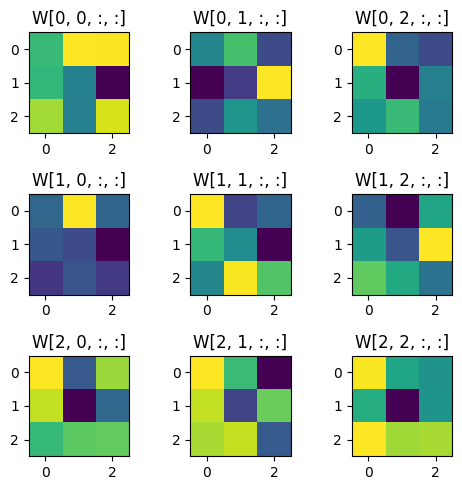

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 生成随机的4维张量
W = np.random.randn(3, 3, 3, 3)

# 可视化每个二维切片
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(W[i, j], cmap='viridis')
        axs[i, j].set_title(f"W[{i}, {j}, :, :]")

# 调整子图布局
plt.tight_layout()
plt.show()

### 6.1.2.1 平移不变性

现在引用上述的第一个原则：平移不变性。
这意味着检测对象在输入$\mathbf{X}$中的平移，应该仅导致隐藏表示$\mathbf{H}$中的平移。也就是说，$\mathsf{V}$和$\mathbf{U}$实际上**不依赖于$(i, j)$的值**，即$[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$。并且$\mathbf{U}$是一个常数，比如$u$。因此，我们可以简化$\mathbf{H}$定义为：
$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b} \tag{6.1.2}$$
这就是**卷积（convolution）**。我们是在使用系数$[\mathbf{V}]_{a, b}$对位置$(i, j)$附近的像素$(i+a, j+b)$进行加权得到$[\mathbf{H}]_{i, j}$。
注意，$[\mathbf{V}]_{a, b}$的系数比$[\mathsf{V}]_{i, j, a, b}$少很多，因为前者不再依赖于图像中的位置。这就是显著的进步！

- **示例：公式6.1.2计算，局部性与平移不变性**

In [2]:
import numpy as np

def convolution2d(X, V, u):
    """
    计算二维卷积，返回隐藏表示 H。

    参数：
    X (numpy.ndarray): 输入二维图像矩阵。
    V (numpy.ndarray): 卷积核权重矩阵。
    u (float): 偏置参数。

    返回：
    H (numpy.ndarray): 隐藏表示矩阵。
    """
    # 获取输入图像和卷积核的形状
    X_height, X_width = X.shape
    V_height, V_width = V.shape
    
    # 计算输出图像的尺寸
    H_height = X_height - V_height + 1
    H_width = X_width - V_width + 1
    
    # 初始化输出图像
    H = np.zeros((H_height, H_width))
    
    # 计算卷积操作
    for i in range(H_height):
        for j in range(H_width):
            # 对应公式 (6.1.2)，计算隐藏表示 H 的每个元素
            H[i, j] = u + np.sum(X[i:i+V_height, j:j+V_width] * V)
            
    return H

# 示例输入
X = np.array([[1, 2, 3, 0],
              [4, 5, 6, 1],
              [7, 8, 9, 0],
              [0, 1, 0, 1]])

V = np.array([[1, 0],
              [0, -1]])

u = 1  # 偏置参数

# 计算卷积
H = convolution2d(X, V, u)

print("输入图像 X:")
print(X)
print("\n卷积核 V:")
print(V)
print("\n偏置参数 u:", u)
print("\n隐藏表示 H:")
print(H)

# 现在，我们通过平移输入图像来验证平移不变性
X_shifted = np.roll(X, shift=2, axis=0)  # 在垂直方向上平移一行

H_shifted = convolution2d(X_shifted, V, u)

print("\n平移后的输入图像 X_shifted:")
print(X_shifted)
print("\n平移后的隐藏表示 H_shifted:")
print(H_shifted)

输入图像 X:
[[1 2 3 0]
 [4 5 6 1]
 [7 8 9 0]
 [0 1 0 1]]

卷积核 V:
[[ 1  0]
 [ 0 -1]]

偏置参数 u: 1

隐藏表示 H:
[[-3. -3.  3.]
 [-3. -3.  7.]
 [ 7.  9.  9.]]

平移后的输入图像 X_shifted:
[[7 8 9 0]
 [0 1 0 1]
 [1 2 3 0]
 [4 5 6 1]]

平移后的隐藏表示 H_shifted:
[[ 7.  9.  9.]
 [-1. -1.  1.]
 [-3. -3.  3.]]


### 6.1.2.2 局部性

现在引用上述的第二个原则：局部性。如上所述，为了收集用来训练参数$[\mathbf{H}]_{i, j}$的相关信息，我们不应偏离到距$(i, j)$很远的地方。这意味着在$|a|> \Delta$或$|b| > \Delta$的范围之外，我们可以设置$[\mathbf{V}]_{a, b} = 0$。因此，我们可以将$[\mathbf{H}]_{i, j}$重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}  \tag{6.1.3}$$


简而言之，公式6.1.3 是一个**卷积层（convolutional layer）**，而卷积神经网络是包含卷积层的一类特殊的神经网络。
在深度学习研究社区中，$\mathbf{V}$被称为**卷积核（convolution kernel）**或者**滤波器（filter）**，亦或简单地称之为该卷积层的**权重**，通常该权重是可学习的参数。
当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，**多层感知机可能需要数十亿个参数来表示网络中的一层，而现在卷积神经网络通常只需要几百个参数**，而且不需要改变输入或隐藏表示的维数。
参数大幅减少的代价是，我们的特征现在是平移不变的，并且当确定每个隐藏活性值时，每一层只包含局部的信息。
以上所有的权重学习都将依赖于归纳偏置。当这种偏置与现实相符时，我们就能得到样本有效的模型，并且这些模型能很好地泛化到未知数据中。
但如果这偏置与现实不符时，比如当图像不满足平移不变时，我们的模型可能难以拟合我们的训练数据。

- **要点：**
  - 公式6.1.3是一个卷积操作，它描述了如何通过将卷积核（或滤波器）$V$与输入数据$X$进行局部相关运算来计算输出的隐藏表示$H$。
  - **局部性原则**：根据局部性原则，在计算隐藏表示$H$时，我们只关注距离$(i,j)$较近的区域，这意味着在$|a|>\Delta$ 或 $|b|>\Delta$ 的范围之外，我们可以设置$[V]_{a,b}=0$。这样，我们就可以在计算每个隐藏单元时仅考虑附近的输入信息。
  - **卷积层**：公式6.1.3定义了一个卷积层，其中$V$是卷积核，$X$是输入数据，$H$是输出数据。卷积层是一种特殊的神经网络层，它利用局部性原则和权重共享来减少参数数量并捕捉图像等数据的平移不变特征。
  - **参数数量显著减少**：与传统的多层感知机相比，卷积神经网络在处理图像等具有局部结构的数据时，参数数量可以大幅减少。这有助于降低过拟合风险，提高模型的泛化能力。
  - **平移不变性**：卷积神经网络在训练过程中学习到的特征具有平移不变性，即使图像发生平移，这些特征也能被有效地检测出来。<br><br>

- **说明：公式6.1.3**
  - **初始化**：将输出矩阵$H$的元素$[H]_{i,j}$ 初始化为常数项$u$。
  - **遍历卷积核**：对于卷积核$V$的每个元素$[V]_{a,b}$（其中$a$和$b$的范围是$-\Delta$ 到$\Delta$），执行以下步骤：
     - **选择输入矩阵$X$的局部区域**：根据局部性原则，选取距离$(i,j)$较近的局部区域（索引为$(i+a,j+b)$）。
     - **计算加权和**：将卷积核元素$[V]_{a,b}$ 与对应的输入矩阵元素$[X]_{i+a,j+b}$ 相乘，然后将结果累加到输出矩阵$[H]_{i,j}$
  - **结果**：经过遍历卷积核后，我们得到了输出矩阵$H$。这个矩阵表示了通过卷积操作捕捉到的局部特征。

- **示例：公式6.1.3计算**

In [3]:
import numpy as np

# 输入矩阵X (3x3)
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# 卷积核V (2x2)
V = np.array([[1, 0],
              [0, 1]])

# 偏置项u
u = 1

# 初始化输出矩阵H (2x2)
H = np.zeros((2, 2))

# 根据公式6.1.3计算卷积操作
delta = V.shape[0] // 2
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        H[i, j] = u
        for a in range(-delta, delta + 1):
            for b in range(-delta, delta + 1):
                if 0 <= i + a < X.shape[0] and 0 <= j + b < X.shape[1]:
                    # 注意这里访问V矩阵的索引已经修改为a和b。
                    H[i, j] += V[a, b] * X[i + a, j + b]

print("输出矩阵H：")
print(H)


输出矩阵H：
[[ 7. 13.]
 [15. 26.]]


## 6.1.3 卷积

- 在进一步讨论之前，我们先简要回顾一下为什么上面的操作被称为卷积。在数学中，两个函数（比如$f, g: \mathbb{R}^d \to \mathbb{R}$）之间的“卷积”被定义为

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}. \tag{6.1.4}$$
- 公式6.1.4中：
   - $ \mathbf{x} $ 是当前的输入位置（或者时间点，视具体问题而定）。
   - $ \mathbf{z} $ 是一个积分变量，表示在函数 $ f $ 上的所有可能的位置。
   - $ g(\mathbf{x}-\mathbf{z}) $ 表示函数 $ g $ 的翻转和平移。
也就是说，**卷积是当把一个函数“翻转”并移位$\mathbf{x}$时，测量$f$和$g$之间的重叠**。

- 当为离散对象时，积分就变成求和。例如：对于由索引为$\mathbb{Z}$的、平方可和的、无限维向量集合中抽取的向量，我们得到以下定义：

  $$(f * g)(i) = \sum_a f(a) g(i-a).\tag{6.1.5}$$
- 在公式6.1.5离散卷积的定义中：
    - $ i $ 是当前的输入位置的索引。
    - $ a $ 是遍历 $ f $ 的所有索引。
    - $ g(i-a) $ 表示函数 $ g $ 的翻转和平移。

- 对于二维张量，则为$f$的索引$(a, b)$和$g$的索引$(i-a, j-b)$上的对应加和：

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).\tag{6.1.6}$$
- 在公式6.1.6二维卷积中：
    - $ (i, j) $ 是输入图像的位置索引。
    - $ (a, b) $ 是 $ f $ 的索引。
    - $ g(i-a, j-b) $ 表示二维卷积核 $ g $ 的翻转和平移。
- 这看起来类似于公式6.1.3，但有一个主要区别：这里不是使用$(i+a, j+b)$，而是使用差值。
- 然而，这种区别是表面的，因为我们总是可以匹配公式6.1.3 和公式6.1.6之间的符号。
- 我们在公式6.1.3中的原始定义更正确地描述了**互相关（cross-correlation）**。

- 卷积与互相关。在卷积神经网络中，卷积操作通常被实现为互相关（cross-correlation），其定义是：
  $$
  (f * g)(i, j) = \sum_a \sum_b f(i+a, j+b) g(a, b). \tag{6.1.7}
  $$
  - 注意到，这里的索引是 $ g(a, b) $ 而不是 $ g(i-a, j-b) $，这意味着**没有对卷积核进行翻转**。
  - 因此严格来说，卷积神经网络中的“卷积”操作更准确地描述为互相关操作而非卷积。

---------------------------
- **说明：**
- **（1）示例：公式6.1.6计算**

In [4]:
import numpy as np

# 输入矩阵f (3x3)
f = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# 输入矩阵g (2x2)
g = np.array([[1, 0],
              [0, 1]])

# 初始化输出矩阵h (2x2)
h = np.zeros((2, 2))

# 遍历结果矩阵h的每个元素(i, j)
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        # 计算每个有效的a和b
        for a in range(f.shape[0]):
            for b in range(f.shape[1]):
                if 0 <= i - a < g.shape[0] and 0 <= j - b < g.shape[1]:
                    h[i, j] += f[a, b] * g[i - a, j - b]

print("输出矩阵h：")
print(h)

输出矩阵h：
[[1. 2.]
 [4. 6.]]


- **（2）卷积运算的计算过程**
  - 计算h(0,0)，遍历f矩阵的所有元素(a, b)，并执行以下操作：
    - a. 对于a=0, b=0，计算f(0, 0)*g(0-0, 0-0) = f(0, 0)g(0, 0) = 1\*1 = 1。
    - b. 对于a=0, b=1，计算f(0, 1)*g(0-0, 0-1)。由于g(0, -1)超出了g矩阵的范围，因此跳过该项。
    - c. 对于a=1, b=0，计算f(1, 0)*g(0-1, 0-0) = f(1, 0)*g(-1, 0)。由于g(-1, 0)超出了g矩阵的范围，因此跳过该项。 
    - d. 其他所有组合的a和b都会导致访问g矩阵时越界，因此忽略它们。
    - 将以上有效乘积相加得到：h(0,0) = 1。
  - 类似地计算其他元素：
    - a. h(0, 1) = f(0, 0)*g(0, -1) + f(0, 1)*g(0, 0) + f(1, 0)*g(-1, -1) + f(1, 1)*g(-1, 0) = 0 + 2\*1 + 0 + 0 = 2。
    - b. h(1, 0) = f(0, 0)*g(-1, 0) + f(0, 1)*g(-1, -1) + f(1, 0)*g(0, 0) + f(1, 1)*g(0, -1) = 0 + 0 + 4\*1 + 0 = 4。
    - c. h(1, 1) = f(0, 0)*g(1, 1) + f(1, 1)*g(0,1 ) + f(0, 1)*g(1, 0)  + f(1, 0)*g(0, 1) + f(1, 1)*g(0, 0) =1\*1 + 5\*0 + 2\*0 + 5\*0 + 5\*1 = 6。

- **（3）公式6.1.7互相关运算**
  - $f$ 是输入数据（在这个例子中是一个3x3的矩阵），它代表了输入信号或图像。
  - $g$ 是卷积核或滤波器（在这个例子中是一个2x2的矩阵），它在输入数据上滑动，以执行卷积或互相关操作。
  - 代码的逻辑反映了互相关（cross-correlation）的过程，虽然在深度学习中这通常也被称为卷积：
    - 卷积核 `g` 在输入 `f` 上滑动。
    - 在每个位置，`g` 的元素与 `f` 中相应位置的元素相乘，然后这些乘积相加得到 `h` 的一个元素。
  - 虽然理论上卷积要求对 `g` 进行翻转，但实际上如下代码实现的操作（`f[i + a, j + b] * g[a, b]`）是**互相关**，因为卷积核 `g` **没有被翻转**。
  - 这在机器学习和图像处理中是很常见的做法，因为卷积核的权重是在训练过程中学习的，翻转的需求**通过学习过程隐式地被考虑**了。

In [5]:
import numpy as np

# 输入矩阵f (3x3)
f = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# 输入矩阵g (2x2)
g = np.array([[1, 0],
              [0, 1]])

# 初始化输出矩阵h (2x2)
h = np.zeros((2, 2))

# 遍历结果矩阵h的每个元素(i, j)
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        # 计算每个有效的a和b
        for a in range(g.shape[0]):
            for b in range(g.shape[1]):
                if 0 <= i + a < f.shape[0] and 0 <= j + b < f.shape[1]:
                    h[i, j] += f[i + a, j + b] * g[a, b]

print("输出矩阵h：")
print(h)

输出矩阵h：
[[ 6.  8.]
 [12. 14.]]


------------

## 6.1.4 “沃尔多在哪里”回顾

回到上面的“沃尔多在哪里”游戏，让我们看看它到底是什么样子。卷积层根据滤波器$\mathbf{V}$选取给定大小的窗口，并加权处理图片，如 图6.1.2中所示。我们的目标是学习一个模型，以便探测出在“沃尔多”最可能出现的地方。

![发现沃尔多。](../img/waldo-mask.jpg)
<center>图6.1.2 发现沃尔多</center>

### 6.1.4.1 通道

然而这种方法有一个问题：我们忽略了图像一般包含三个通道/三种原色（红色、绿色和蓝色）。
实际上，图像不是二维张量，而是一个**由高度、宽度和颜色组成的三维张量**，比如包含$1024 \times 1024 \times 3$个像素。
前两个轴与像素的空间位置有关，而第三个轴可以看作是每个像素的多维表示。
因此，我们将$\mathsf{X}$索引为$[\mathsf{X}]_{i, j, k}$。由此卷积相应地调整为$[\mathsf{V}]_{a,b,c}$，而不是$[\mathbf{V}]_{a,b}$。

**此外，由于输入图像是三维的，我们的隐藏表示$\mathsf{H}$也最好采用三维张量。**
换句话说，对于每一个空间位置，我们想要采用**一组**而**不是一个隐藏表示**。这样一组隐藏表示可以想象成一些**互相堆叠的二维网格。**
因此，我们可以把隐藏表示想象为一系列具有二维张量的**通道**（channel）。
这些通道有时也被称为**特征映射**（feature maps），因为每个通道都向后续层提供一组**空间化的学习特征**。
直观上你可以想象在靠近输入的底层，一些通道专门识别边缘，而一些通道专门识别纹理。

为了支持输入$\mathsf{X}$和隐藏表示$\mathsf{H}$中的多个通道，我们可以在$\mathsf{V}$中添加第四个坐标，即$[\mathsf{V}]_{a, b, c, d}$。综上所述，

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},\tag{6.1.7}$$


其中隐藏表示$\mathsf{H}$中的索引$d$表示输出通道，而随后的输出将继续以三维张量$\mathsf{H}$作为输入进入下一个卷积层。
所以，公式6.1.7可以定义具有多个通道的卷积层，而其中$\mathsf{V}$是该卷积层的权重。

然而，仍有许多问题亟待解决。
例如，图像中是否到处都有存在沃尔多的可能？如何有效地计算输出层？如何选择适当的激活函数？为了训练有效的网络，如何做出合理的网络设计选择？我们将在本章的其它部分讨论这些问题。



In [6]:
import numpy as np

def conv_multi_channel(X, V):
    # 获取输入图像、卷积核和输出图像的尺寸
    input_height, input_width, input_channels = X.shape
    kernel_height, kernel_width, _, output_channels = V.shape
    
    # 计算输出图像的尺寸
    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    # 初始化输出特征映射张量 H
    H = np.zeros((output_height, output_width, output_channels))

    # 遍历输出特征映射的每个空间位置 (i, j) 和输出通道 d
    for i in range(output_height):
        for j in range(output_width):
            for d in range(output_channels):
                # 对于给定的 (i, j, d)，计算卷积操作的结果
                for a in range(kernel_height):
                    for b in range(kernel_width):
                        for c in range(input_channels):
                            H[i, j, d] += V[a, b, c, d] * X[i + a, j + b, c]

    return H

# 示例输入图像
X = np.array([
    [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
])

# 示例权重张量
V = np.random.randn(2, 2, 3, 4)

# 计算卷积操作的结果
H = conv_multi_channel(X, V)

print(H)


[[[ -9.04839085  -6.76912689 -28.19314552 -27.52369053]
  [-10.96430951  -6.33330347 -54.69633147 -52.10264428]]

 [[ -9.04839085  -6.76912689 -28.19314552 -27.52369053]
  [-10.96430951  -6.33330347 -54.69633147 -52.10264428]]]


## 小结

- 图像的平移不变性使我们以相同的方式处理局部图像，而不在乎它的位置。
- 局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。
- 在图像处理中，卷积层通常比全连接层需要更少的参数，但依旧获得高效用的模型。
- 卷积神经网络（CNN）是一类特殊的神经网络，它可以包含多个卷积层。
- 多个输入和输出通道使模型在每个空间位置可以获取图像的多方面特征。
